In [21]:
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.inspection import permutation_importance
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import f_regression, chi2
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings('ignore')

# base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Важная настройка для корректной настройки pipeline!
import sklearn
sklearn.set_config(transform_output="pandas")

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder, TargetEncoder
from sklearn.model_selection import GridSearchCV, KFold

# for model learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

#models
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from catboost import CatBoostRegressor

# Metrics
from sklearn.metrics import accuracy_score


# tunning hyperparamters model
import optuna

In [22]:
df = pd.read_csv('~/house-prices-advanced-regression-techniques/train.csv')

In [23]:
# Добавление новой фичи - отлогарифмированной цены: df['LogSalePrice'] = np.log(df['SalePrice'])
df

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
2            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
3            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
4            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
...          ...       ...  ...      ...    ...    ...         ...     ...   
1455         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1456         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
1457         Lvl    AllPub  ...        0    NaN  GdPrv        Shed    2500   
1458         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1459         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
0         2   2008        WD         Normal     208500  
1         5   2007        WD         Normal     181500  
2         9   2008        WD         Normal     223500  
3         2   2006        WD        Abnorml     140000  
4        12   2008        WD         Normal     250000  
...     ...    ...       ...            ...        ...  
1455      8   2007        WD         Normal     175000  
1456      2   2010        WD         Normal     210000  
1457      5   2010        WD         Normal     266500  
1458      4   2010        WD         Normal     142125  
1459      6   2008        WD         Normal     147500  

[1460 rows x 81 columns]

In [24]:
num_features = df.select_dtypes(exclude='object') # 37
cat_features = df.select_dtypes(include='object') # 43
num_features.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [25]:
pd.DataFrame(data={'NaN_count': num_features.isna().sum(), 'data_type':num_features.dtypes})

NaN_count data_type
Id                     0     int64
MSSubClass             0     int64
LotFrontage          259   float64
LotArea                0     int64
OverallQual            0     int64
OverallCond            0     int64
YearBuilt              0     int64
YearRemodAdd           0     int64
MasVnrArea             8   float64
BsmtFinSF1             0     int64
BsmtFinSF2             0     int64
BsmtUnfSF              0     int64
TotalBsmtSF            0     int64
1stFlrSF               0     int64
2ndFlrSF               0     int64
LowQualFinSF           0     int64
GrLivArea              0     int64
BsmtFullBath           0     int64
BsmtHalfBath           0     int64
FullBath               0     int64
HalfBath               0     int64
BedroomAbvGr           0     int64
KitchenAbvGr           0     int64
TotRmsAbvGrd           0     int64
Fireplaces             0     int64
GarageYrBlt           81   float64
GarageCars             0     int64
GarageArea             0     int64
WoodDeckSF             0     int64
OpenPorchSF            0     int64
EnclosedPorch          0     int64
3SsnPorch              0     int64
ScreenPorch            0     int64
PoolArea               0     int64
MiscVal                0     int64
MoSold                 0     int64
YrSold                 0     int64
SalePrice              0     int64

In [26]:
# Год постройки гаража
df['GarageYrBlt'].value_counts()
# Я бы удалил данный столбец

# Площадь облицовки каменной кладки в квадратных футах
df['MasVnrArea'].value_counts()
# Заполним модой - 0.0 or KNN

# Длина улицы в линейных футах, соединенной с объектом недвижимости
df['LotFrontage'].value_counts()
# Пока что KNN


LotFrontage
60.0     143
70.0      70
80.0      69
50.0      57
75.0      53
        ... 
137.0      1
141.0      1
38.0       1
140.0      1
46.0       1
Name: count, Length: 110, dtype: int64

In [20]:
# Заполнение пропусков в ячейках

columns_to_drop = ['Id','SalePrice','GarageYrBlt']


my_imputer = ColumnTransformer(
    transformers = [
        ('drop_features', 'drop', columns_to_drop),
        ('num_imputer', KNNImputer(n_neighbors=5), num_features.columns)
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)

In [27]:
scaler_and_encoder = ColumnTransformer(
    [
        ('scaling_num_columns', StandardScaler(), num_features.columns)
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)

In [28]:
preprocessor = Pipeline(
    [
        ('imputer', my_imputer),
        ('scaler_and_encoder', scaler_and_encoder)
    ]
)

In [29]:
df_fitted = preprocessor.fit_transform(df)

In [30]:
df_fitted

Id  MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  \
0    -1.730865    0.073375    -0.245897 -0.207142     0.651479    -0.517200   
1    -1.728492   -0.872563     0.397151 -0.091886    -0.071836     2.179628   
2    -1.726120    0.073375    -0.117287  0.073480     0.651479    -0.517200   
3    -1.723747    0.309859    -0.460246 -0.096897     0.651479    -0.517200   
4    -1.721374    0.073375     0.568630  0.375148     1.374795    -0.517200   
...        ...         ...          ...       ...          ...          ...   
1455  1.721374    0.073375    -0.374506 -0.260560    -0.071836    -0.517200   
1456  1.723747   -0.872563     0.611500  0.266407    -0.071836     0.381743   
1457  1.726120    0.309859    -0.203027 -0.147810     0.651479     3.078570   
1458  1.728492   -0.872563    -0.117287 -0.080160    -0.795151     0.381743   
1459  1.730865   -0.872563     0.182802 -0.058112    -0.795151     0.381743   

      YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  GarageType  \
0      1.050994      0.878668    0.509456    0.575425  ...      Attchd   
1      0.156734     -0.429577   -0.574822    1.171992  ...      Attchd   
2      0.984752      0.830215    0.321367    0.092907  ...      Attchd   
3     -1.863632     -0.720298   -0.574822   -0.499274  ...      Detchd   
4      0.951632      0.733308    1.361389    0.463568  ...      Attchd   
...         ...           ...         ...         ...  ...         ...   
1455   0.918511      0.733308   -0.574822   -0.973018  ...      Attchd   
1456   0.222975      0.151865    0.083490    0.759659  ...      Attchd   
1457  -1.002492      1.024029   -0.574822   -0.369871  ...      Attchd   
1458  -0.704406      0.539493   -0.574822   -0.865548  ...      Attchd   
1459  -0.207594     -0.962566   -0.574822    0.847389  ...      Attchd   

      GarageFinish  GarageQual  GarageCond  PavedDrive  PoolQC  Fence  \
0              RFn          TA          TA           Y     NaN    NaN   
1              RFn          TA          TA           Y     NaN    NaN   
2              RFn          TA          TA           Y     NaN    NaN   
3              Unf          TA          TA           Y     NaN    NaN   
4              RFn          TA          TA           Y     NaN    NaN   
...            ...         ...         ...         ...     ...    ...   
1455           RFn          TA          TA           Y     NaN    NaN   
1456           Unf          TA          TA           Y     NaN  MnPrv   
1457           RFn          TA          TA           Y     NaN  GdPrv   
1458           Unf          TA          TA           Y     NaN    NaN   
1459           Fin          TA          TA           Y     NaN    NaN   

      MiscFeature  SaleType  SaleCondition  
0             NaN        WD         Normal  
1             NaN        WD         Normal  
2             NaN        WD         Normal  
3             NaN        WD        Abnorml  
4             NaN        WD         Normal  
...           ...       ...            ...  
1455          NaN        WD         Normal  
1456          NaN        WD         Normal  
1457         Shed        WD         Normal  
1458          NaN        WD         Normal  
1459          NaN        WD         Normal  

[1460 rows x 81 columns]

In [46]:
X = df_fitted.drop(columns=['SalePrice'])
y = df_fitted['SalePrice']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
X

Id  MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  \
0    -1.730865    0.073375    -0.245897 -0.207142     0.651479    -0.517200   
1    -1.728492   -0.872563     0.397151 -0.091886    -0.071836     2.179628   
2    -1.726120    0.073375    -0.117287  0.073480     0.651479    -0.517200   
3    -1.723747    0.309859    -0.460246 -0.096897     0.651479    -0.517200   
4    -1.721374    0.073375     0.568630  0.375148     1.374795    -0.517200   
...        ...         ...          ...       ...          ...          ...   
1455  1.721374    0.073375    -0.374506 -0.260560    -0.071836    -0.517200   
1456  1.723747   -0.872563     0.611500  0.266407    -0.071836     0.381743   
1457  1.726120    0.309859    -0.203027 -0.147810     0.651479     3.078570   
1458  1.728492   -0.872563    -0.117287 -0.080160    -0.795151     0.381743   
1459  1.730865   -0.872563     0.182802 -0.058112    -0.795151     0.381743   

      YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  GarageType  \
0      1.050994      0.878668    0.509456    0.575425  ...      Attchd   
1      0.156734     -0.429577   -0.574822    1.171992  ...      Attchd   
2      0.984752      0.830215    0.321367    0.092907  ...      Attchd   
3     -1.863632     -0.720298   -0.574822   -0.499274  ...      Detchd   
4      0.951632      0.733308    1.361389    0.463568  ...      Attchd   
...         ...           ...         ...         ...  ...         ...   
1455   0.918511      0.733308   -0.574822   -0.973018  ...      Attchd   
1456   0.222975      0.151865    0.083490    0.759659  ...      Attchd   
1457  -1.002492      1.024029   -0.574822   -0.369871  ...      Attchd   
1458  -0.704406      0.539493   -0.574822   -0.865548  ...      Attchd   
1459  -0.207594     -0.962566   -0.574822    0.847389  ...      Attchd   

      GarageFinish  GarageQual  GarageCond  PavedDrive  PoolQC  Fence  \
0              RFn          TA          TA           Y     NaN    NaN   
1              RFn          TA          TA           Y     NaN    NaN   
2              RFn          TA          TA           Y     NaN    NaN   
3              Unf          TA          TA           Y     NaN    NaN   
4              RFn          TA          TA           Y     NaN    NaN   
...            ...         ...         ...         ...     ...    ...   
1455           RFn          TA          TA           Y     NaN    NaN   
1456           Unf          TA          TA           Y     NaN  MnPrv   
1457           RFn          TA          TA           Y     NaN  GdPrv   
1458           Unf          TA          TA           Y     NaN    NaN   
1459           Fin          TA          TA           Y     NaN    NaN   

      MiscFeature  SaleType  SaleCondition  
0             NaN        WD         Normal  
1             NaN        WD         Normal  
2             NaN        WD         Normal  
3             NaN        WD        Abnorml  
4             NaN        WD         Normal  
...           ...       ...            ...  
1455          NaN        WD         Normal  
1456          NaN        WD         Normal  
1457         Shed        WD         Normal  
1458          NaN        WD         Normal  
1459          NaN        WD         Normal  

[1460 rows x 80 columns]

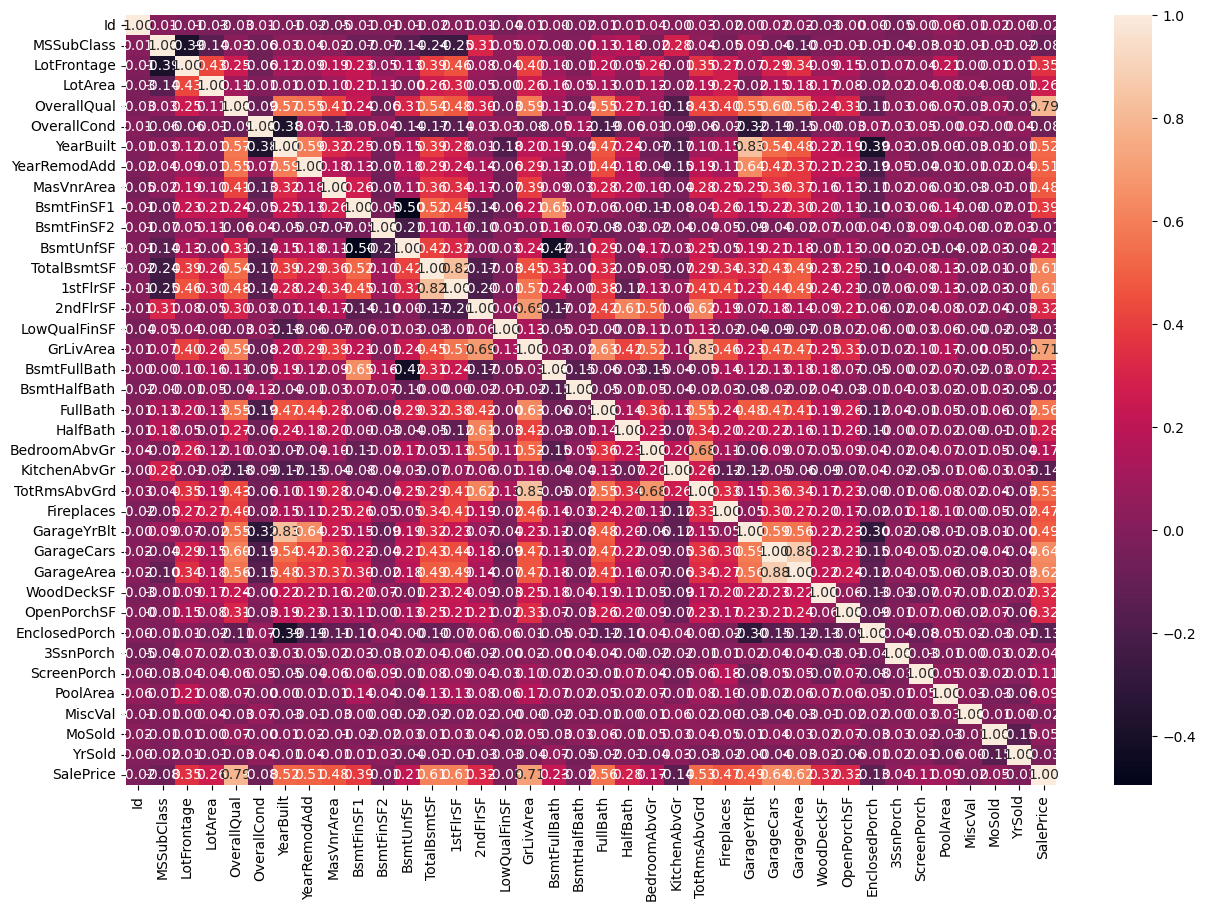

In [40]:
plt.rcParams['figure.figsize'] = [15,10]
sns.heatmap(num_features.corr(), annot=True, fmt='.2f');

In [42]:
num_features.corr()['SalePrice'][:-1].sort_values(key=lambda x: abs(x), ascending=False)

OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass      -0.084284
OverallCond     -0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold          -0.028923
LowQualFinSF    -0.025606
Id              -0.021917
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
Name: SalePrice, dtype: float64